In [1]:
# Import all the libraries needed
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go
import plotly.subplots
import json
import os
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder , StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

**DATA IMPORT**

First step for the model building would be to import the data and start Exploratory Data Analysis(EDA)

In [2]:
#Import data and ignore warnings
dframe1 = pd.read_excel("PSP_Jan_Feb_2019.xlsx")
warnings.filterwarnings("ignore")

**Data quality checks**

After importing the data, we explore the data and start treating the data for null values and duplicate values.
We look for correlation between parameters and try to select important features.

In [3]:
dframe1.head()

,Unnamed: 0,tmsp,country,amount,success,PSP,3D_secured,card
0,0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa
1,1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa
2,2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners
3,3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners
4,4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners


In [4]:
# Drop the unwanted row "unnamed : 0", check the number of rows and columns and print first 5 rows
dframe2 = dframe1.drop("Unnamed: 0", axis=1)
print("Number of rows and Columns: ", dframe2.shape)
dframe2.head()

Number of rows and Columns:  (50410, 7)


,tmsp,country,amount,success,PSP,3D_secured,card
0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa
1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa
2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners
3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners
4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners


In [5]:
# Treat the dataframe for duplicate values
print("Data frame with duplicate values : " ,dframe2.shape[0])
dframe3 = dframe2.drop_duplicates()
print("Data frame without duplicate values : " ,dframe3.shape[0])

Data frame with duplicate values :  50410
Data frame without duplicate values :  50329


In [6]:
# Check the dataframe for null values
dframe3.isnull().sum()

tmsp          0
country       0
amount        0
success       0
PSP           0
3D_secured    0
card          0
dtype: int64

In [7]:
# Check the dataframe for the number of unique values
dframe3.nunique()

tmsp          50121
country           3
amount          517
success           2
PSP               4
3D_secured        2
card              3
dtype: int64

In [8]:
# A look into the types of data we have
dframe3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50329 entries, 0 to 50409
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   tmsp        50329 non-null  datetime64[ns]
 1   country     50329 non-null  object        
 2   amount      50329 non-null  int64         
 3   success     50329 non-null  int64         
 4   PSP         50329 non-null  object        
 5   3D_secured  50329 non-null  int64         
 6   card        50329 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 3.1+ MB


In [9]:
# Explore the basic statistic data parameters
dframe3.describe()

,amount,success,3D_secured
count,50329.000000,50329.000000,50329.000000
mean,202.379622,0.203223,0.238312
std,96.255629,0.402401,0.426055
min,6.000000,0.000000,0.000000
25%,133.000000,0.000000,0.000000
50%,201.000000,0.000000,0.000000
75%,269.000000,0.000000,0.000000
max,630.000000,1.000000,1.000000


In [10]:
#Get PSP values for loading transaction fees in the next step
print("PSP unique values : " ,dframe3['PSP'].unique())

PSP unique values :  ['UK_Card' 'Simplecard' 'Moneycard' 'Goldcard']


In [11]:
# Loading PSP transaction fees as a dataframe
psp_dframe = pd.DataFrame({"PSP":["Moneycard","Goldcard","UK_Card","Simplecard"],"success_txn_fee":[5,10,3,1],"failure_txn_fee":[2,5,1,0.5]})
display(psp_dframe.head())

,PSP,success_txn_fee,failure_txn_fee
0,Moneycard,5,2.0
1,Goldcard,10,5.0
2,UK_Card,3,1.0
3,Simplecard,1,0.5


In [12]:
# Merge psp_dframe with main dataframe dframe3
dframe4 = pd.merge(dframe3, psp_dframe, how='left', on='PSP')
dframe4.head()

,tmsp,country,amount,success,PSP,3D_secured,card,success_txn_fee,failure_txn_fee
0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa,3,1.0
1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa,3,1.0
2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners,3,1.0
3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners,3,1.0
4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners,1,0.5


In [13]:
dframe4["tmsp"] = pd.to_datetime(dframe4["tmsp"])

# Sort the dataframe by timestamp in ascending order
dframe4.sort_values(["tmsp"], inplace=True)

# Finding the time difference between the consecutive timestamps
dframe4["tmsp_dif"] = dframe4["tmsp"] - dframe4["tmsp"].shift(1)
dframe4.reset_index(inplace=True)
dframe4.drop(["index"], axis=1, inplace=True)

# Converting the delta in time into seconds
dframe4["tmsp_dif"]  = dframe4["tmsp_dif"].apply(lambda x: x.total_seconds())

# Assigned value 1 if the transaction is done within a minute after the previous transaction and assigning value 0 if it is not done within a minute
dframe4["withinMinute"] =  dframe4["tmsp_dif"].apply(lambda x: 1 if x<=60 else 0)

# Introducing a new feature ‘NoOfAttempts’ which captures the number of transaction attempts based on the given criteria and assigning an initial value of 1 for all records
dframe4["NoOfAttempts"] = 1

# Incrementing the parameter 'NoOfAttempts' consequently if withinMinute = 1
# If the transaction amount and country is the same and if the transaction is retried within a minute, the transaction is a reattempt from the same customer
for i, r in dframe4.iterrows():
     if i< dframe4.shape[0]-1:
          if (dframe4["country"][i] == dframe4["country"][i+1]) & (dframe4["amount"][i] == dframe4["amount"][i+1]) & (dframe4["withinMinute"][i+1]<=60):
            dframe4["NoOfAttempts"][i+1] = dframe4["NoOfAttempts"][i] + 1
dframe4.head()

,tmsp,country,amount,success,PSP,3D_secured,card,success_txn_fee,failure_txn_fee,tmsp_dif,withinMinute,NoOfAttempts
0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa,3,1.0,NaN,0,1
1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa,3,1.0,6.0,1,2
2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners,3,1.0,92.0,0,1
3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners,3,1.0,24.0,1,2
4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners,1,0.5,80.0,0,1


In [14]:
# Fill 0 for values with NaN in tmsp_dif column to avoid issues
dframe4["tmsp_dif"] = dframe4["tmsp_dif"].fillna(0)

# Encoding the values before EDA - Label encoding
dframe5 = dframe4.copy()
categorical_colunmns = ["country","PSP", "card"]
label_encoder = LabelEncoder()
for col in categorical_colunmns:
        dframe5[col] = label_encoder.fit_transform(dframe5[col])
        print(col,":", label_encoder.classes_)
dframe5.sample(5)

country : ['Austria' 'Germany' 'Switzerland']
PSP : ['Goldcard' 'Moneycard' 'Simplecard' 'UK_Card']
card : ['Diners' 'Master' 'Visa']


,tmsp,country,amount,success,PSP,3D_secured,card,success_txn_fee,failure_txn_fee,tmsp_dif,withinMinute,NoOfAttempts
37001,2019-02-12 05:52:36,1,152,1,3,0,0,3,1.0,124.0,0,1
33052,2019-02-07 13:06:28,0,272,1,1,0,1,5,2.0,185.0,0,1
6327,2019-01-07 04:01:41,1,76,0,1,1,1,5,2.0,63.0,0,1
1982,2019-01-02 15:25:58,1,434,1,3,1,1,3,1.0,14.0,1,2
9001,2019-01-09 22:15:17,0,265,1,1,1,1,5,2.0,40.0,1,3


In [15]:
# Encoding the values before EDA - one-hot encoding
dframe6 = dframe4.copy()
dframe6 = pd.get_dummies(dframe6, columns = categorical_colunmns, drop_first = True)

print(dframe6.shape)
dframe6.head()

(50329, 16)


,tmsp,amount,success,3D_secured,success_txn_fee,failure_txn_fee,tmsp_dif,withinMinute,NoOfAttempts,country_Germany,country_Switzerland,PSP_Moneycard,PSP_Simplecard,PSP_UK_Card,card_Master,card_Visa
0,2019-01-01 00:01:11,89,0,0,3,1.0,0.0,0,1,1,0,0,0,1,0,1
1,2019-01-01 00:01:17,89,1,0,3,1.0,6.0,1,2,1,0,0,0,1,0,1
2,2019-01-01 00:02:49,238,0,1,3,1.0,92.0,0,1,1,0,0,0,1,0,0
3,2019-01-01 00:03:13,238,1,1,3,1.0,24.0,1,2,1,0,0,0,1,0,0
4,2019-01-01 00:04:33,124,0,0,1,0.5,80.0,0,1,0,0,0,1,0,0,0


**Exploratory Data Analysis(EDA)**

After cleaning the data, we explore the data and start looking for correlation between parameters and try to select important features.

In [16]:
# Exploring the data trends - Starting it with success rates across PSP, cards and countries
# Calculate the mean success rates for psp category
psp_success_rate = dframe4.groupby(['PSP'])[['success']].mean()
card_success_rate = dframe4.groupby(['card'])[['success']].mean()
country_success_rate = dframe4.groupby(['country'])[['success']].mean()

print("\nPSP Success Rate:")
print(psp_success_rate,end='\n\t')


PSP Success Rate:
             success
PSP                 
Goldcard    0.406172
Moneycard   0.218833
Simplecard  0.158212
UK_Card     0.194861
	

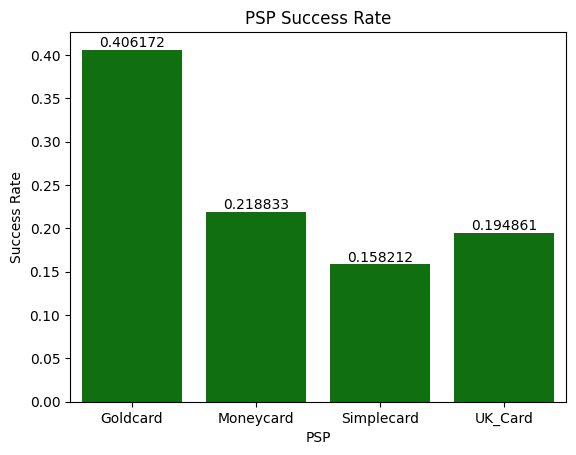

In [17]:
# Plotting PSP Success Rate
plot = sns.barplot(x=psp_success_rate.index, y=psp_success_rate['success'], color='green')
plot.bar_label(plot.containers[0])
plt.title("PSP Success Rate")
plt.ylabel("Success Rate")
plt.show()


Card Success Rate:
         success
card            
Diners  0.223247
Master  0.194252
Visa    0.208756
	

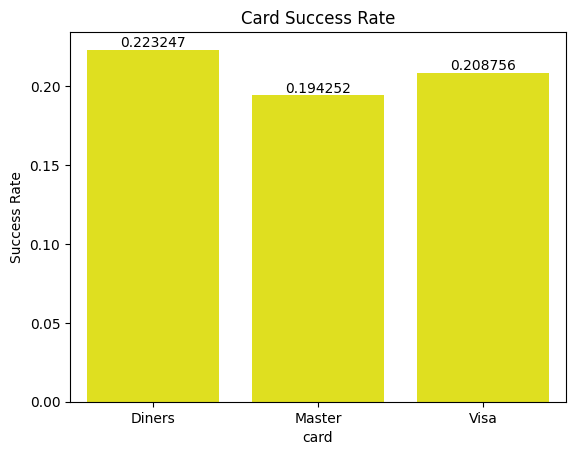

In [18]:
# Calculate Card success rate
print("\nCard Success Rate:")
print(card_success_rate,end='\n\t')
# Plotting Card Success Rate
plot = sns.barplot(x=card_success_rate.index, y=card_success_rate['success'], color='yellow')
plot.bar_label(plot.containers[0])
plt.title("Card Success Rate")
plt.ylabel("Success Rate")
plt.show()


 Country Success Rate:
              success
country              
Austria      0.204969
Germany      0.201696
Switzerland  0.206025
	

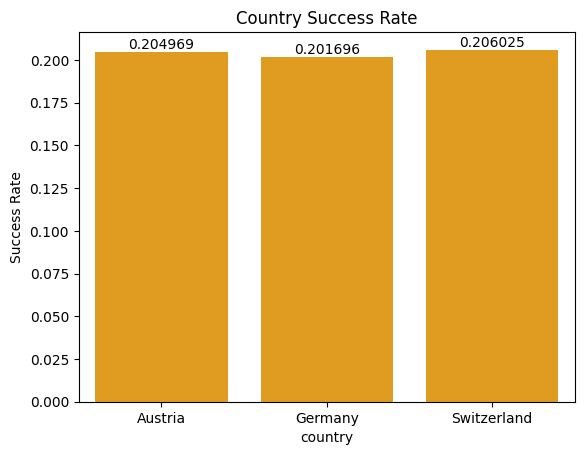

In [19]:
# Calculate Country success rate
print("\n Country Success Rate:" )
print(country_success_rate,end='\n\t')

# Plotting Country Success Rate
plot = sns.barplot(x=country_success_rate.index, y=country_success_rate['success'], color='orange')
plot.bar_label(plot.containers[0])
plt.title("Country Success Rate")
plt.ylabel("Success Rate")
plt.show()

In [20]:
# Country wise PSP Success Rate  :
success_rate_by_psp = dframe4.groupby(['PSP','country'])['success'].mean().reset_index()
success_rate_graph = px.bar(success_rate_by_psp, x='PSP', y='success', text='success', barmode='group', labels={'success': 'Success Rate'}, color='country')
success_rate_graph.update_traces(texttemplate='%{text:.1%}')
success_rate_graph.update_layout(title='Country-wise PSP Success Rates', xaxis_title='PSP', yaxis_title='Success Rate')
success_rate_graph.show()

In [21]:
# Distribution of successful transactions across countries
Txn_count_df = dframe4.groupby(by=["country", "success"]).size().reset_index(name="count")
Txn_across_Countries = px.bar(Txn_count_df, x='country', y='count', text='success', barmode='group', color='success')
Txn_across_Countries.update_layout(title='Distribution of successful transactions across countries', xaxis_title='Country', yaxis_title='Count')
Txn_across_Countries.show()

In [22]:
# Distribution of successful transactions by PSP
Txn_count_df2 = dframe4.groupby(by=["PSP", "success"]).size().reset_index(name="count")
Txn_across_psp = px.bar(Txn_count_df2, x='PSP', y='count', text='success', barmode='group', color='success')
Txn_across_psp.update_layout(title='Distribution of successful transactions across PSPs', xaxis_title='PSP', yaxis_title='Count')
Txn_across_psp.show()

In [23]:
# Distribution of successful transactions by cards
Card_Txn_count_df = dframe4.groupby(by=["card", "success"]).size().reset_index(name="count")
Card_txn = px.bar(Card_Txn_count_df, x='card', y='count', text='success', barmode='group', color='success')
Card_txn.update_layout(title='Distribution of successful transactions across cards', xaxis_title='Card', yaxis_title='Count')
Card_txn.show()

In [24]:
# Grouping by 'number of attempts' and calculating the mean success rate
Number_of_attempt_success_rate = dframe4.groupby('NoOfAttempts')['success'].mean().reset_index()

# Plotting a graph for success rate vs. number of attempts
fig = px.bar(Number_of_attempt_success_rate, x='NoOfAttempts', y='success',
             labels={'success': 'Avg Success Rate', 'NoOfAttempts': 'Number of Attempts'},
             title='Success Rate vs. Number of Attempts')
fig.update_layout(xaxis_type='category')
fig.show()

            Failed_Trxns  Successful_Trxns
PSP                                       
Moneycard           6479              1815
Goldcard            1905              1303
UK_Card            21246              5142
Simplecard         10471              1968


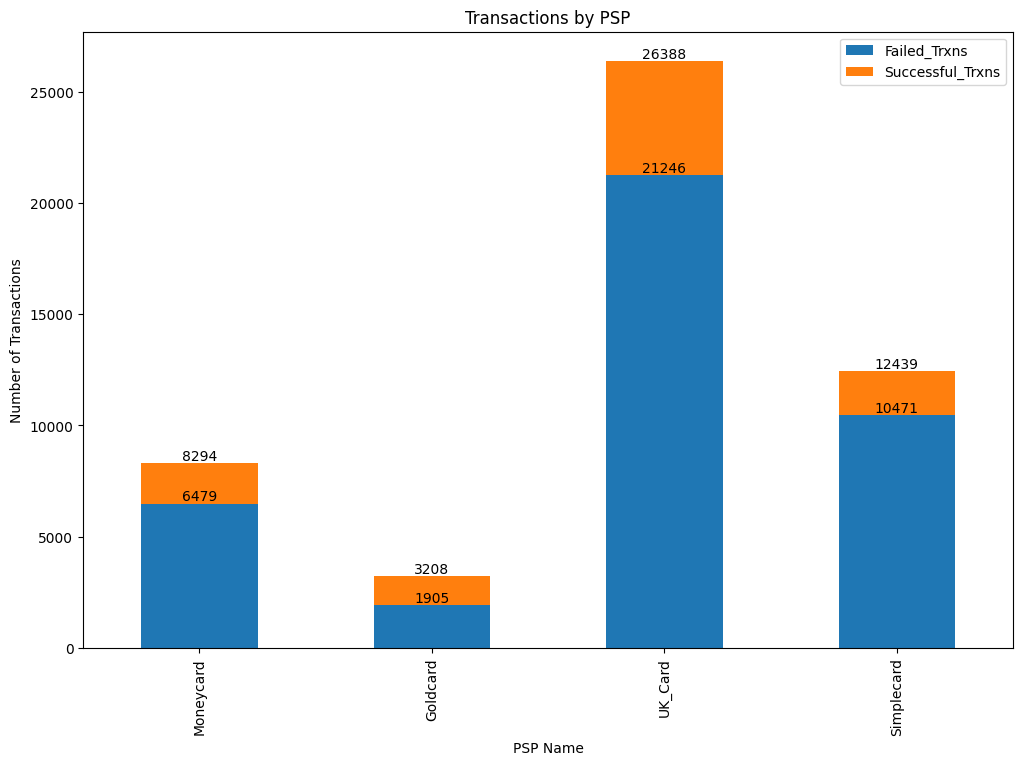

In [25]:
# Amount of transactions by PSP
PSP_Txn_count_df = dframe4.groupby('PSP')['success'].value_counts().unstack(fill_value=0)
PSP_Txn_count_df = PSP_Txn_count_df.loc[psp_dframe['PSP']]

# Rename column for better understanding
PSP_Txn_count_df.columns = ['Failed_Trxns', 'Successful_Trxns']
print(PSP_Txn_count_df)
# Plot the Amount of transactions by PSP chart
plot_Txn_cnt = PSP_Txn_count_df.plot(kind='bar', stacked=True, figsize=(12, 8))
plot_Txn_cnt.bar_label(plot_Txn_cnt.containers[0])
plot_Txn_cnt.bar_label(plot_Txn_cnt.containers[1])
plt.title("Transactions by PSP")
plt.xlabel("PSP Name")
plt.ylabel("Number of Transactions")
plt.show()

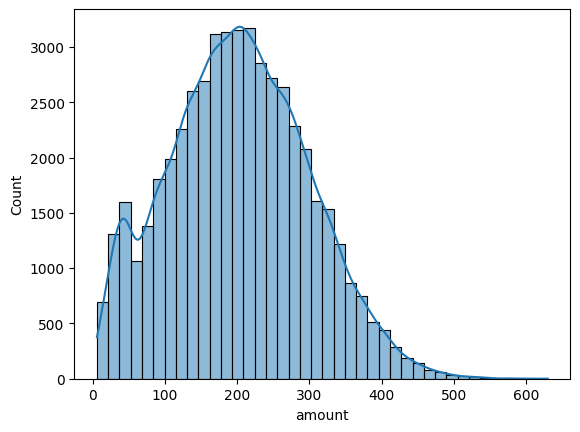

In [26]:
# Plotting a histogram for visualizing the distribution of transaction amount
sns.histplot(dframe4, x='amount', bins=40, kde=True)
plt.show()

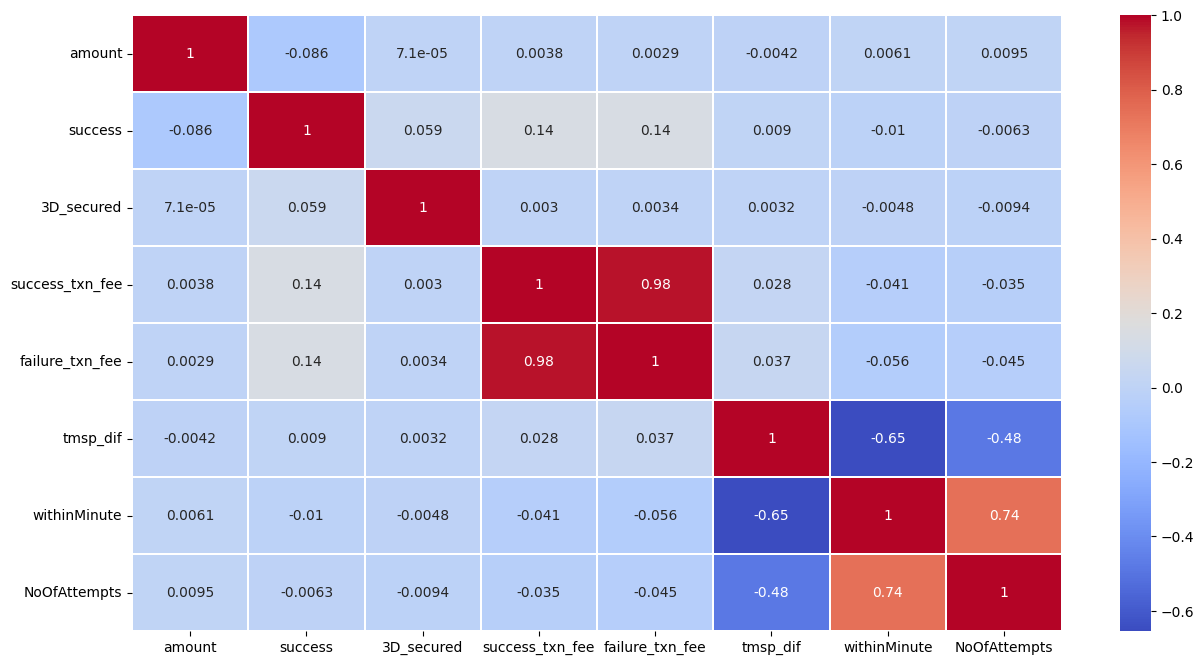

In [27]:
# Heat map for finding correlation between variables
plt.figure(figsize=(15,8))
sns.heatmap(dframe4.corr(),linewidths=.1,cmap="coolwarm", annot=True)
plt.show()

**Data prepocessing**

This includes labeling the data and columns properly and scaling the data before moving onto building models

In [28]:
# next step is to select features and target variable
# Encode all the category columns(Country , PSP and Card) before next step of scaling the data

le = LabelEncoder()
dframe4['country'] = le.fit_transform(dframe4['country'])
dframe4['card'] = le.fit_transform(dframe4['card'])
dframe4['PSP'] = le.fit_transform(dframe4['PSP'])
X = dframe4.drop(['tmsp','success'], axis=1)
Y = dframe4['success']
X.head()

,country,amount,PSP,3D_secured,card,success_txn_fee,failure_txn_fee,tmsp_dif,withinMinute,NoOfAttempts
0,1,89,3,0,2,3,1.0,0.0,0,1
1,1,89,3,0,2,3,1.0,6.0,1,2
2,1,238,3,1,0,3,1.0,92.0,0,1
3,1,238,3,1,0,3,1.0,24.0,1,2
4,0,124,2,0,0,1,0.5,80.0,0,1


**Model building and training**

Next step is to divide this X and Y dataframes into training and testing data for building different models

In [29]:
# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=25)

In [30]:
# Use Standard scaler for scaling X data
datascaler = StandardScaler()
X_train_scaled = datascaler.fit_transform(X_train)
X_test_scaled = datascaler.transform(X_test)

In [31]:
# Predictive Model 1 -Random Forest Classifier
RF_model = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=25)
RF_model.fit(X_train, Y_train)
RF_prediction_model_train = RF_model.predict(X_train)
RF_prediction_model_test = RF_model.predict(X_test)

# Performance metrics of the Random Forest model
print("Training set Metrics:")
print(f"Accuracy: {accuracy_score(Y_train, RF_prediction_model_train):.3f}")
print(f"Precision: {precision_score(Y_train, RF_prediction_model_train, average='weighted'):.3f}")
print(f"Recall: {recall_score(Y_train, RF_prediction_model_train, average='weighted'):.3f}")
print(f"F1 Score: {f1_score(Y_train, RF_prediction_model_train, average='weighted'):.3f}")
print(f"Confusion Matrix:\n{confusion_matrix(Y_train, RF_prediction_model_train)}")

print("\nTesting set Metrics:")
print(f"Accuracy: {accuracy_score(Y_test, RF_prediction_model_test):.3f}")
print(f"Precision: {precision_score(Y_test, RF_prediction_model_test, average='weighted'):.3f}")
print(f"Recall: {recall_score(Y_test, RF_prediction_model_test, average='weighted'):.3f}")
print(f"F1 Score: {f1_score(Y_test, RF_prediction_model_test, average='weighted'):.3f}")
print(f"Confusion Matrix:\n{confusion_matrix(Y_test, RF_prediction_model_test)}")


Training set Metrics:
Accuracy: 0.807
Precision: 0.815
Recall: 0.807
F1 Score: 0.734
Confusion Matrix:
[[31999    89]
 [ 7670   505]]

Testing set Metrics:
Accuracy: 0.800
Precision: 0.767
Recall: 0.800
F1 Score: 0.722
Confusion Matrix:
[[7965   48]
 [1970   83]]


In [32]:
# Predictive Model 2 - RandomizedSearchCV

param_distr = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': [None, 'balanced']
}
RS_model = RandomizedSearchCV(RF_model, param_distr, random_state=25, scoring='accuracy', n_jobs=-1,
                                    cv=5, n_iter=20)
RS_model.fit(X_train, Y_train)
RS_model_test = RS_model.predict(X_test)
RS_model_train = RS_model.predict(X_train)

# Additional Metrics
print("Training set Metrics:")
print(f"Accuracy: {accuracy_score(Y_train, RS_model_train):.3f}")
print(f"Precision: {precision_score(Y_train, RS_model_train, average='weighted'):.3f}")
print(f"Recall: {recall_score(Y_train, RS_model_train, average='weighted'):.3f}")
print(f"F1 Score: {f1_score(Y_train, RS_model_train, average='weighted'):.3f}")
print(f"Confusion Matrix:\n{confusion_matrix(Y_train, RS_model_train)}")

print("\nTesting set Metrics:")
print(f"Accuracy: {accuracy_score(Y_test, RS_model_test):.3f}")
print(f"Precision: {precision_score(Y_test, RS_model_test, average='weighted'):.3f}")
print(f"Recall: {recall_score(Y_test, RS_model_test, average='weighted'):.3f}")
print(f"F1 Score: {f1_score(Y_test, RS_model_test, average='weighted'):.3f}")
print(f"Confusion Matrix:\n{confusion_matrix(Y_test, RS_model_test)}")


Training set Metrics:
Accuracy: 0.805
Precision: 0.802
Recall: 0.805
F1 Score: 0.730
Confusion Matrix:
[[31971   117]
 [ 7741   434]]

Testing set Metrics:
Accuracy: 0.801
Precision: 0.782
Recall: 0.801
F1 Score: 0.723
Confusion Matrix:
[[7977   36]
 [1968   85]]


In [33]:
# Predictive Model 3 - Gradient boost
Gradient_boost_predictive_model = GradientBoostingClassifier(random_state=25)
Gradient_boost_predictive_model.fit(X_train, Y_train)
GB_predictions_test = Gradient_boost_predictive_model.predict(X_test)
GB_predictions_train = Gradient_boost_predictive_model.predict(X_train)

# Performance metrics of the Gradient boost model
print("Training set Metrics:")
print(f"Accuracy : {accuracy_score(Y_train, GB_predictions_train):.3f}")
print(f"Precision: {precision_score(Y_train, GB_predictions_train, average='weighted'):.3f}")
print(f"Recall: {recall_score(Y_train, GB_predictions_train, average='weighted'):3f}")
print(f"F1 Score: {f1_score(Y_train, GB_predictions_train, average='weighted'):.3f}")
print(f"Confusion Matrix:\n{confusion_matrix(Y_train, GB_predictions_train)}")

print("\nTesting set Metrics:")
print(f"Accuracy : {accuracy_score(Y_test, GB_predictions_test):.3f}")
print(f"Precision: {precision_score(Y_test, GB_predictions_test, average='weighted'):.3f}")
print(f"Recall: {recall_score(Y_test, GB_predictions_test, average='weighted'):.3f}")
print(f"F1 Score: {f1_score(Y_test, GB_predictions_test, average='weighted'):.3f}")
print(f"Confusion Matrix:\n{confusion_matrix(Y_test, GB_predictions_test)}")


Training set Metrics:
Accuracy : 0.801
Precision: 0.781
Recall: 0.801207
F1 Score: 0.723
Confusion Matrix:
[[31956   132]
 [ 7872   303]]

Testing set Metrics:
Accuracy : 0.802
Precision: 0.793
Recall: 0.802
F1 Score: 0.723
Confusion Matrix:
[[7987   26]
 [1972   81]]


In [34]:
# Predictive Model 4 - LGBM Classifier
LGBM_model = LGBMClassifier(boosting_type='gbdt', num_leaves=31, learning_rate=0.05, n_estimators=100,
                                random_state=25,force_row_wise=True)
LGBM_model.fit(X_train, Y_train)
LGBM_predictions_test = LGBM_model.predict(X_test)
LGBM_predictions_train = LGBM_model.predict(X_train)

# Performance metrics of the LGBM model
print("Training set Metrics:")
print(f"Accuracy: {accuracy_score(Y_train, LGBM_predictions_train):.3f}")
print(f"Precision: {precision_score(Y_train, LGBM_predictions_train, average='weighted'):.3f}")
print(f"Recall: {recall_score(Y_train, LGBM_predictions_train, average='weighted'):.3f}")
print(f"F1 Score: {f1_score(Y_train, LGBM_predictions_train, average='weighted'):.3f}")
print(f"Confusion Matrix:\n{confusion_matrix(Y_train, LGBM_predictions_train)}")

print("\nTesting set Metrics:")
print(f"Accuracy: {accuracy_score(Y_test, LGBM_predictions_test):.3f}")
print(f"Precision: {precision_score(Y_test, LGBM_predictions_test, average='weighted'):.3f}")
print(f"Recall: {recall_score(Y_test, LGBM_predictions_test, average='weighted'):.3f}")
print(f"F1 Score: {f1_score(Y_test, LGBM_predictions_test, average='weighted'):.3f}")
print(f"Confusion Matrix:\n{confusion_matrix(Y_test, LGBM_predictions_test)}")

[LightGBM] [Info] Number of positive: 8175, number of negative: 32088
[LightGBM] [Info] Total Bins 545
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203040 -> initscore=-1.367401
[LightGBM] [Info] Start training from score -1.367401
Training set Metrics:
Accuracy: 0.802
Precision: 0.783
Recall: 0.802
F1 Score: 0.723
Confusion Matrix:
[[31959   129]
 [ 7862   313]]

Testing set Metrics:
Accuracy: 0.801
Precision: 0.791
Recall: 0.801
F1 Score: 0.723
Confusion Matrix:
[[7986   27]
 [1972   81]]


In [35]:
# Predictive Model 5 - XGBClassifier
XGB_model = XGBClassifier(random_state=25)
XGB_model.fit(X_train, Y_train)
XGB_model_predictions_test = XGB_model.predict(X_test)
XGB_model_predictions_train = XGB_model.predict(X_train)

# Performance metrics of the XGB model
print("Training set Metrics:")
print(f"Accuracy: {accuracy_score(Y_train, XGB_model_predictions_train):.3f}")
print(f"Precision: {precision_score(Y_train, XGB_model_predictions_train, average='weighted'):.3f}")
print(f"Recall: {recall_score(Y_train, XGB_model_predictions_train, average='weighted'):.3f}")
print(f"F1 Score: {f1_score(Y_train, XGB_model_predictions_train, average='weighted'):.3f}")
print(f"Confusion Matrix:\n{confusion_matrix(Y_train, XGB_model_predictions_train)}")

print("\nTesting set Metrics:")
print(f"Accuracy: {accuracy_score(Y_test, XGB_model_predictions_test):.3f}")
print(f"Precision: {precision_score(Y_test, XGB_model_predictions_test, average='weighted'):.3f}")
print(f"Recall: {recall_score(Y_test, XGB_model_predictions_test, average='weighted'):.3f}")
print(f"F1 Score: {f1_score(Y_test, XGB_model_predictions_test, average='weighted'):.3f}")
print(f"Confusion Matrix:\n{confusion_matrix(Y_test, XGB_model_predictions_test)}")


Training set Metrics:
Accuracy: 0.817
Precision: 0.826
Recall: 0.817
F1 Score: 0.757
Confusion Matrix:
[[31935   153]
 [ 7201   974]]

Testing set Metrics:
Accuracy: 0.796
Precision: 0.743
Recall: 0.796
F1 Score: 0.726
Confusion Matrix:
[[7898  115]
 [1935  118]]
